# Fall 2023 Practicum - NRG Energy

See the README for project setup.

In [1]:
# conda env export --from-history -f environment.yml

In [2]:
# numpy
import numpy as np 
from numpy import mean
from numpy import std

# pandas
import pandas as pd

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.datasets import make_classification

from sklearn.preprocessing import StandardScaler

# plots
import seaborn as sns
import matplotlib.pyplot as plt 

# oversampling
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE 

# for pickle file
import pickle
import os

Read in the training and test datasets. Convert the dates to year and month.

Note: The test data fields are transformed/imputed at the same time as the training data.

In [3]:
ecoshare = pd.read_excel("/Users/deborahchang/Downloads/ecoshare_sales_v3.xlsx")
ecoshare_test = pd.read_csv("/Users/deborahchang/Downloads/ecoshare_sales_test.csv")


ecoshare['order_day'] = pd.to_datetime(ecoshare['order_day'])
ecoshare['order_day_year'] = ecoshare['order_day'].dt.year
ecoshare['order_day_month'] = ecoshare['order_day'].dt.month

ecoshare_test['order_day'] = pd.to_datetime(ecoshare_test['order_day'])
ecoshare_test['order_day_year'] = ecoshare_test['order_day'].dt.year
ecoshare_test['order_day_month'] = ecoshare_test['order_day'].dt.month

/var/folders/2s/nzk1fw0x62xdf8yb0lzjh7040000gn/T/ipykernel_6748/3105240603.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  ecoshare_test = pd.read_csv("/Users/deborahchang/Downloads/ecoshare_sales_test.csv")


# EDA

Calculate the proportion of calls that result in an EcoShare acceptance.

In [4]:
ecoshare.accept.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    83.1%
1    16.9%
Name: accept, dtype: object

Almost 17% of all calls result in an EcoShare acceptance.

#### Acceptances over Time

Here we look at the trend of acceptances over time.

<AxesSubplot:xlabel='order_day'>

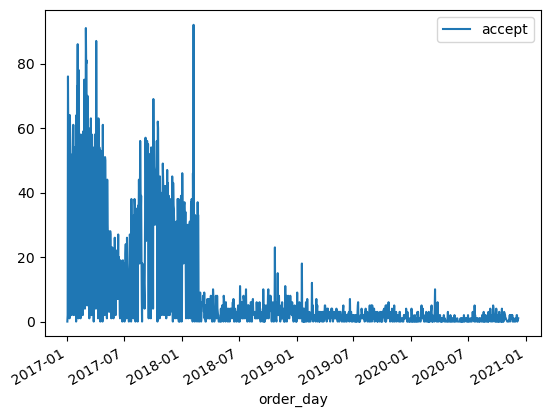

In [5]:
ecoshare_accept_only = ecoshare[['order_day', 'accept']]
grouped = ecoshare_accept_only.groupby('order_day').sum()
grouped.plot()

Here, we look at the trends by year.

<AxesSubplot:xlabel='order_day_year'>

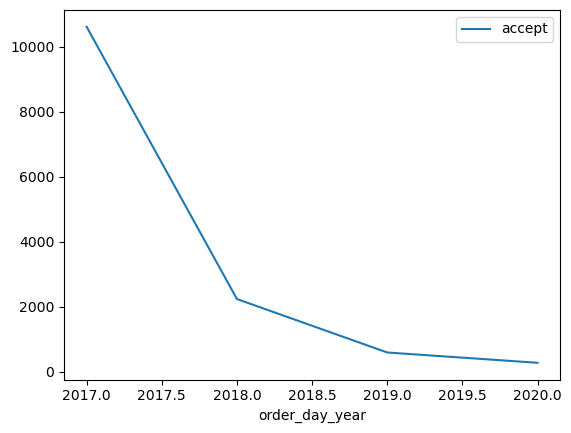

In [6]:
ecoshare_accept_only = ecoshare[['order_day_year', 'accept']]
grouped = ecoshare_accept_only.groupby('order_day_year').sum()
grouped.plot()

#### Product Patterns

We look at the volume of acceptances by plan.

In [7]:
ecoshare_accept_only = ecoshare[['sap_productname','accept']]
ecoshare_accept_only.groupby(['sap_productname']).sum().sort_values(['accept'], ascending=False)

,accept
sap_productname,
Reliant Flex plan,2309
Reliant Secure 12 plan,1933
Reliant Truly Free Weekends 12 plan,1387
Reliant Secure Advantage 12 plan,814
Reliant Secure 24 plan,769
...,...
Reliant Secure 22 plan,0
Pollution Free Connect,0
Reliant Secure 24 ePlan,0


Most of the acceptances are for Reliant plans, volumewise. Let's see it proportionwise.

In [8]:

grouped = ecoshare.groupby('sap_productname').agg({'accept': ['count', 'sum']})
grouped['%'] = grouped['accept']['sum']/grouped['accept']['count'] *100

grouped['counts']=grouped['accept']['count']
grouped['sums']=grouped['accept']['sum']


top_5_plans = grouped.sort_values(by='sums', ascending = False).iloc[0:5].index
top_5_df_graph = ecoshare[ecoshare['sap_productname'].isin(top_5_plans)][['accept', 'order_day_year', 'meter_id', 'sap_productname']]

top_5_df_graph = top_5_df_graph.groupby(['sap_productname', 'order_day_year']).agg({'accept': ['count', 'sum']})
top_5_df_graph['%'] = top_5_df_graph['accept']['sum']/top_5_df_graph['accept']['count'] *100

top_5_df_graph


accept                %
                                                    count   sum           
sap_productname                     order_day_year                        
Reliant Flex plan                   2017             7741  1915  24.738406
                                    2018             2895   326  11.260794
                                    2019             2528    38   1.503165
                                    2020             2443    30   1.227998
Reliant Secure 12 plan              2017             6001  1701  28.345276
                                    2018             1186   169  14.249578
                                    2019              894    49   5.480984
                                    2020              899    14   1.557286
Reliant Secure 24 plan              2017             1629   603  37.016575
                                    2018              545   113  20.733945
                                    2019              869    39   4.487917
                                    2020              584    14   2.397260
Reliant Secure Advantage 12 plan    2017             2092   693  33.126195
                                    2018              477   100  20.964361
                                    2019              372    12   3.225806
                                    2020              163     9   5.521472
Reliant Truly Free Weekends 12 plan 2017             2154  1190  55.246054
                                    2018              500   156  31.200000
                                    2019              362    33   9.116022
                                    2020              244     8   3.278689

Proportionwise, the top 5 plans that tend to result in meter-level acceptances are Reliant. The top 10 plans with the most acceptances, which are Reliant, make up almost 70% of all acceptances.

The top 5 plans were graphed in the "top 5 plans" tab in the google sheet shared in the repo.

#### Web Activity

Here we graph the number of logins within the past month over time.

<AxesSubplot:xlabel='order_day_year'>

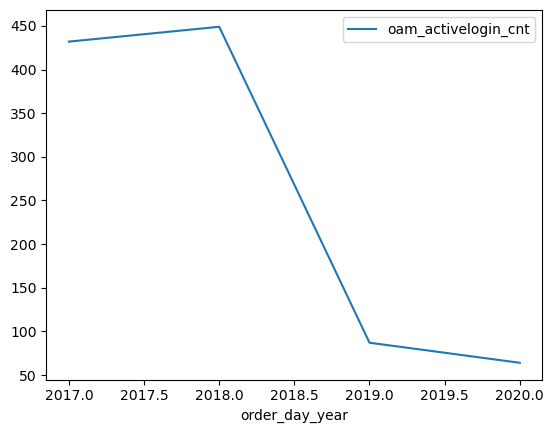

In [9]:
ecoshare_eda = ecoshare[['order_day_year', 'oam_activelogin_cnt']]
grouped = ecoshare_eda.groupby('order_day_year').sum()
grouped.plot()

It seems that the logins follow a similar trend as the acceptances trend. 

Below, we look at the trend for website visits.

<AxesSubplot:xlabel='order_day_year'>

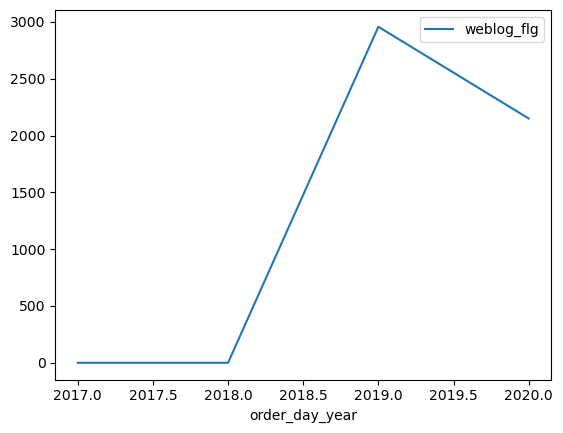

In [10]:
ecoshare['weblog_flg'] = ecoshare['weblog_flg'].astype('category').cat.codes
ecoshare_test['weblog_flg'] = ecoshare_test['weblog_flg'].astype('category').cat.codes

ecoshare_eda = ecoshare[['order_day_year', 'weblog_flg']]
grouped = ecoshare_eda.groupby('order_day_year').sum()
grouped.plot()

The trend for whether the customer visited the website in the past month seems to be almost the opposite as with acceptances - the peak from 2018-2020 corresponds with the decline in acceptances. Maybe there were more issues with the plans and more people were logging into the website, hence less attention on EcoShare.

Below is a distribution of whether the customer has an account or not - it seems to follow the acceptances trend a bit.

<AxesSubplot:xlabel='order_day_year'>

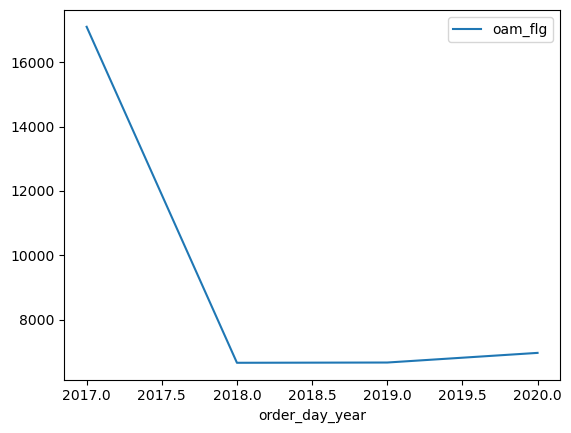

In [11]:
ecoshare['oam_flg'] = ecoshare['oam_flg'].astype('category').cat.codes
ecoshare_test['oam_flg'] = ecoshare_test['oam_flg'].astype('category').cat.codes

ecoshare_eda = ecoshare[['order_day_year', 'oam_flg']]
grouped = ecoshare_eda.groupby('order_day_year').sum()
grouped.plot()

Below is a distribution of the number of pageviews the customer experienced on Reliant's website within the past month.

<AxesSubplot:xlabel='order_day_year'>

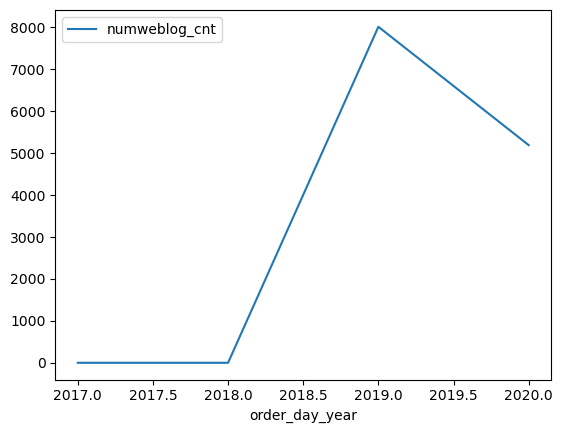

In [12]:
ecoshare_eda = ecoshare[['order_day_year', 'numweblog_cnt']]
grouped = ecoshare_eda.groupby('order_day_year').sum()
grouped.plot()

This shows a very similar trend as with weblog_flg - more web visits can lead to more pageviews.

#### Calls

Here, we compare the distribution of calls for acceptances and rejections. The first graph below shows the trend for acceptances and the second for rejections of EcoShare.

Text(0.5, 1.0, 'Rejections')

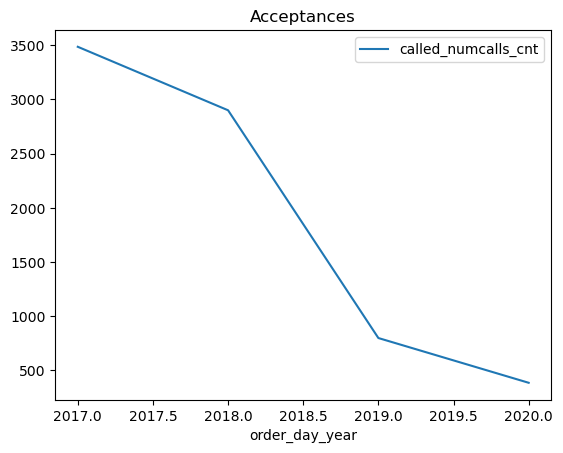

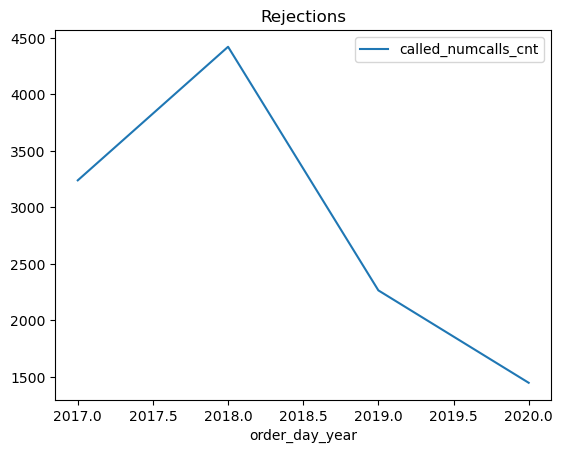

In [13]:
# called numcalls cnt
ecoshare_tl_accept = ecoshare.loc[ecoshare['accept'] == 1,]
ecoshare_tl_accept = ecoshare_tl_accept[['order_day_year', 'called_numcalls_cnt']]

ecoshare_tl_reject = ecoshare.loc[ecoshare['accept'] == 0,]
ecoshare_tl_reject = ecoshare_tl_reject[['order_day_year', 'called_numcalls_cnt']]

grouped = ecoshare_tl_accept.groupby('order_day_year').sum()
grouped.plot()
plt.title('Acceptances')
grouped = ecoshare_tl_reject.groupby('order_day_year').sum()
grouped.plot()
plt.title('Rejections')

It seems like the number of times the customer called Reliant's call center within the past month correlates with acceptances, which makes sense since the more a customer calls, the more willingness there may be to accept EcoShare.

#### Late Fee

Below shows the comparison for whether the customer was charged a late fee for not paying their Reliant electricity bill on time within the past month. The first graph below shows the trend for acceptances and the second for rejections of EcoShare.

<AxesSubplot:xlabel='order_day_year'>

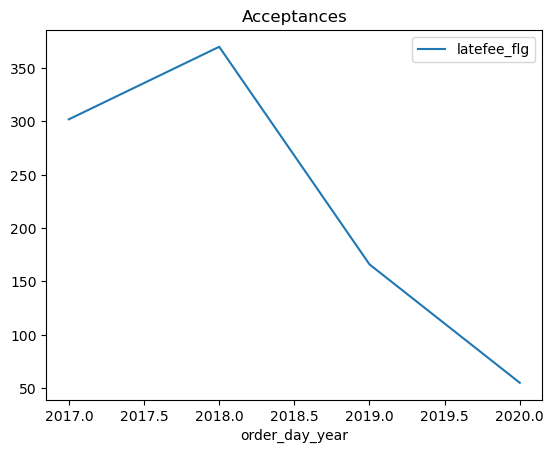

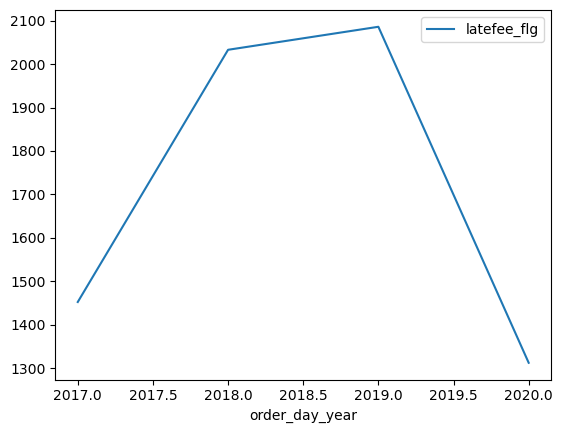

In [14]:
# latefee_flg
# latefee_flg # convert to categorical -- # 1 = Y, 0 = No

ecoshare['latefee_flg'] = ecoshare['latefee_flg'].astype('category').cat.codes
ecoshare_test['latefee_flg'] = ecoshare_test['latefee_flg'].astype('category').cat.codes

ecoshare_tl_accept = ecoshare.loc[ecoshare['accept'] == 1,]
ecoshare_tl_accept = ecoshare_tl_accept[['order_day_year', 'latefee_flg']]

ecoshare_tl_reject = ecoshare.loc[ecoshare['accept'] == 0,]
ecoshare_tl_reject = ecoshare_tl_reject[['order_day_year', 'latefee_flg']]

grouped = ecoshare_tl_accept.groupby('order_day_year').sum()
grouped.plot()
plt.title('Acceptances')
grouped = ecoshare_tl_reject.groupby('order_day_year').sum()
grouped.plot()

#### Disconnects

Below shows the distribution for whether the customer's electricity service was disconnected within the past month. Based on the comparison between acceptances and rejections (first versus second chart below), the directional trend seems to be similar for disconnects and acceptances.

Text(0.5, 1.0, 'Rejections')

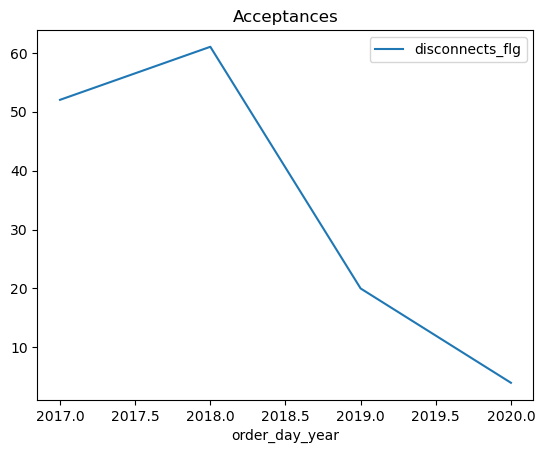

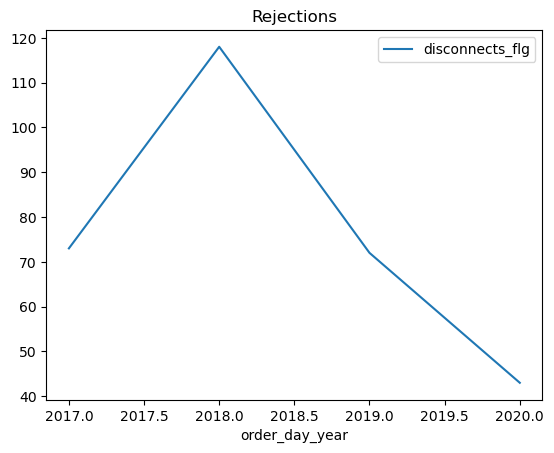

In [15]:
# disconnects_flg 0= No, 1 = Yes
ecoshare['disconnects_flg'] = ecoshare['disconnects_flg'].astype('category').cat.codes
ecoshare_test['disconnects_flg'] = ecoshare_test['disconnects_flg'].astype('category').cat.codes

ecoshare_tl_accept = ecoshare.loc[ecoshare['accept'] == 1,]
ecoshare_tl_accept = ecoshare_tl_accept[['order_day_year', 'disconnects_flg']]

ecoshare_tl_reject = ecoshare.loc[ecoshare['accept'] == 0,]
ecoshare_tl_reject = ecoshare_tl_reject[['order_day_year', 'disconnects_flg']]

grouped = ecoshare_tl_accept.groupby('order_day_year').sum()
grouped.plot()
plt.title('Acceptances')
grouped = ecoshare_tl_reject.groupby('order_day_year').sum()
grouped.plot()
plt.title('Rejections')

#### Risk Level

The acceptance rate by risk over time was graphed in the "risk" tab in the google sheets. Below shows the tabular view:

In [16]:
# risk level 3 = Not Provided, 2 = M, 0 = H, 1 = L
ecoshare['risk_level'].fillna("Not Provided", inplace=True) 
ecoshare_test['risk_level'].fillna("Not Provided", inplace=True) 

ecoshare_tl_accept = ecoshare[['order_day_year', 'risk_level', 'accept']]

grouped = ecoshare_tl_accept.groupby(['risk_level','order_day_year']).agg({'accept': ['count', 'sum']})
grouped['%'] = grouped['accept']['sum']/grouped['accept']['count'] *100
grouped

accept                %
                             count   sum           
risk_level   order_day_year                        
H            2017              794   260  32.745592
             2018             1601   422  26.358526
             2019              835   129  15.449102
             2020              447    45  10.067114
L            2017             6124   607   9.911822
             2018            10106   833   8.242628
             2019            10256   309   3.012871
             2020            10616   163   1.535418
M            2017              833   312  37.454982
             2018             2889   982  33.991000
             2019             1412   154  10.906516
             2020              669    67  10.014948
Not Provided 2017            34733  9441  27.181643

#### Electronic Payment

Below is a comparison for acceptances versus rejections (first versus second graph) on the basis of whether the customer receives their electricity bills electronically. There seems to be some correlation for acceptances here, as the trend follows similarly.

Text(0.5, 1.0, 'Rejections')

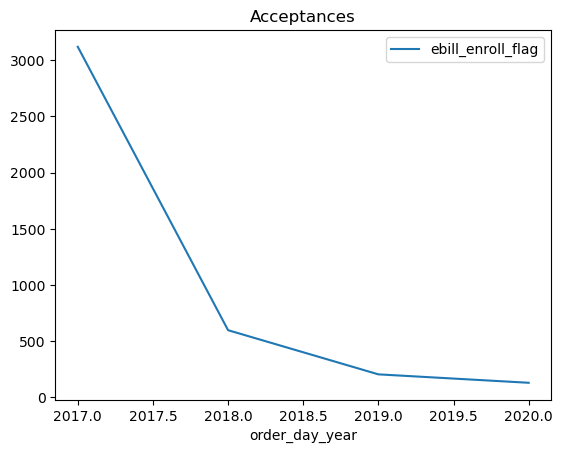

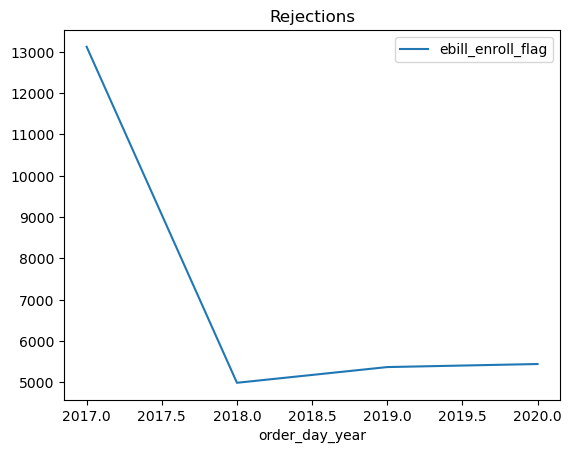

In [17]:
# ebill_enroll_flag # convert to categorical
ecoshare['ebill_enroll_flag'] = ecoshare['ebill_enroll_flag'].astype('category').cat.codes
ecoshare_test['ebill_enroll_flag'] = ecoshare_test['ebill_enroll_flag'].astype('category').cat.codes

ecoshare_tl_accept = ecoshare.loc[ecoshare['accept'] == 1,]
ecoshare_tl_accept = ecoshare_tl_accept[['order_day_year', 'ebill_enroll_flag']]

ecoshare_tl_reject = ecoshare.loc[ecoshare['accept'] == 0,]
ecoshare_tl_reject = ecoshare_tl_reject[['order_day_year', 'ebill_enroll_flag']]

grouped = ecoshare_tl_accept.groupby('order_day_year').sum()
grouped.plot()
plt.title('Acceptances')
grouped = ecoshare_tl_reject.groupby('order_day_year').sum()
grouped.plot()
plt.title('Rejections')

#### Disconnotice

Below shows the EcoShare acceptances versus rejections (first versus second graph below) distribution for whether the customer recently received a disconnect notice from Reliant for not paying their electricity bill.

Text(0.5, 1.0, 'Rejections')

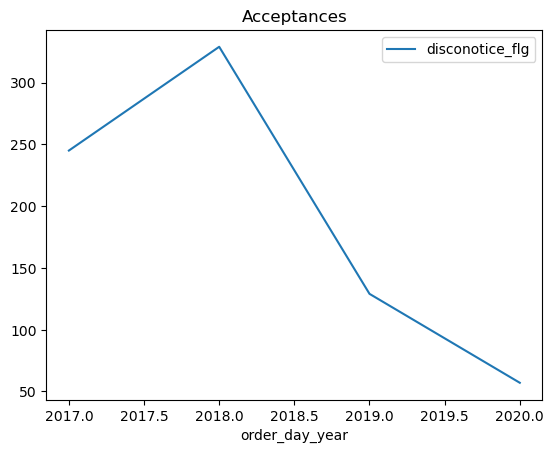

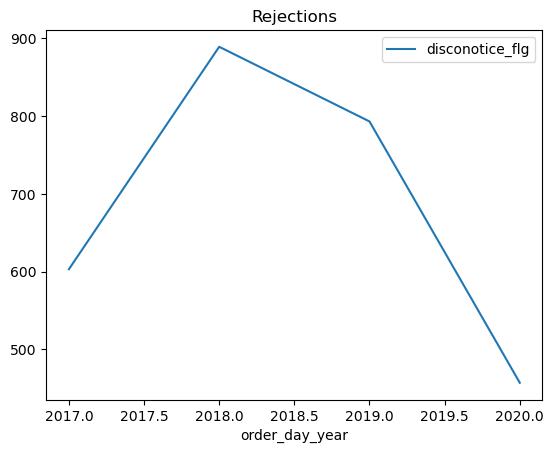

In [18]:
# disconotice_flg

ecoshare['disconotice_flg'] = ecoshare['disconotice_flg'].astype('category').cat.codes
ecoshare_test['disconotice_flg'] = ecoshare_test['disconotice_flg'].astype('category').cat.codes

ecoshare_tl_accept = ecoshare.loc[ecoshare['accept'] == 1,]
ecoshare_tl_accept = ecoshare_tl_accept[['order_day_year', 'disconotice_flg']]

ecoshare_tl_reject = ecoshare.loc[ecoshare['accept'] == 0,]
ecoshare_tl_reject = ecoshare_tl_reject[['order_day_year', 'disconotice_flg']]

grouped = ecoshare_tl_accept.groupby('order_day_year').sum()
grouped.plot()
plt.title('Acceptances')
grouped = ecoshare_tl_reject.groupby('order_day_year').sum()
grouped.plot()
plt.title('Rejections')

#### Calls Flag

Below shows the comparison for whether the customer called within the past month.

Text(0.5, 1.0, 'Rejections')

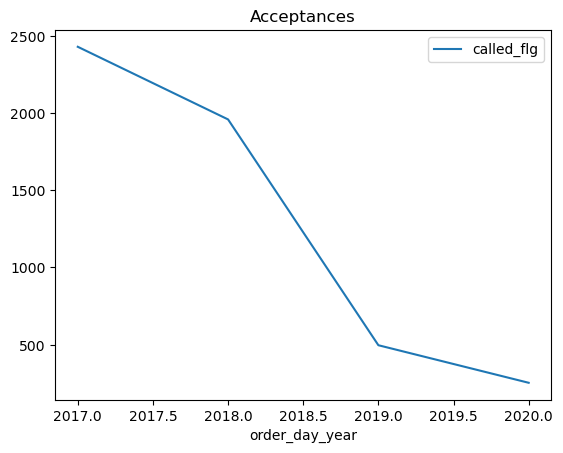

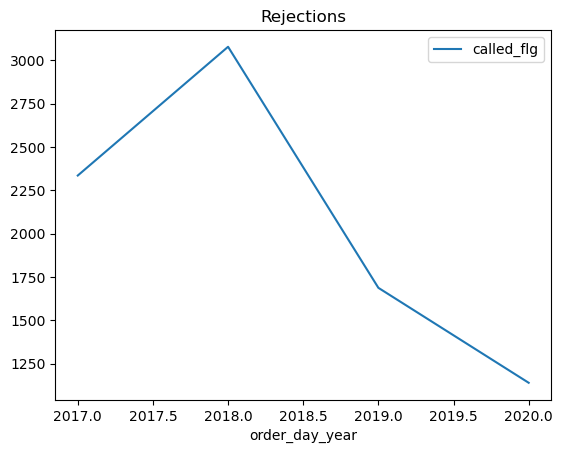

In [19]:
#called_flg # convert to categorical 0 = no, 1 = yes
ecoshare['called_flg'] = ecoshare['called_flg'].astype('category').cat.codes
ecoshare_test['called_flg'] = ecoshare_test['called_flg'].astype('category').cat.codes

ecoshare_tl_accept = ecoshare.loc[ecoshare['accept'] == 1,]
ecoshare_tl_accept = ecoshare_tl_accept[['order_day_year', 'called_flg']]

ecoshare_tl_reject = ecoshare.loc[ecoshare['accept'] == 0,]
ecoshare_tl_reject = ecoshare_tl_reject[['order_day_year', 'called_flg']]

grouped = ecoshare_tl_accept.groupby('order_day_year').sum()
grouped.plot()
plt.title('Acceptances')
grouped = ecoshare_tl_reject.groupby('order_day_year').sum()
grouped.plot()
plt.title('Rejections')

In terms of acceptances, there seems to be a correlation of the number of calls with the acceptances over time.

#### Current Usage 

Here, we look at the average usage over time.

Text(0.5, 1.0, 'Average Usage over Time')

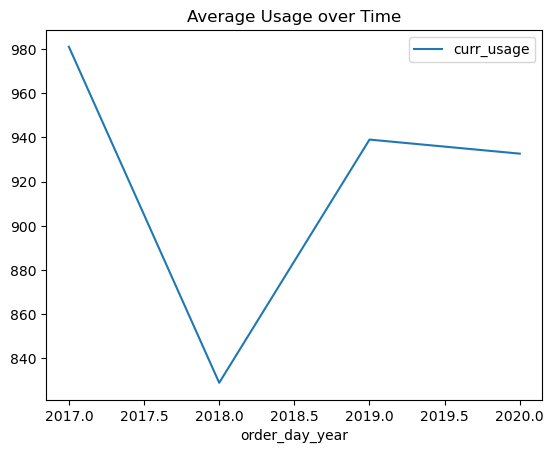

In [20]:
# check trend of usage over time
#ecoshare.plot('order_day', 'accept')
ecoshare['curr_usage'].fillna(ecoshare['curr_usage'].mean(), inplace=True)
ecoshare_test['curr_usage'].fillna(ecoshare_test['curr_usage'].mean(), inplace=True)


ecoshare_usage = ecoshare[['order_day_year', 'curr_usage']]
grouped = ecoshare_usage.groupby('order_day_year').mean()
grouped.plot()
plt.title('Average Usage over Time')



Here, we compare the average usage for customers who accepted versus rejected EcoShare - usage seems to gradually increase for customers who accepted EcoShare, whereas for rejections there was a dip in 2018.

Text(0.5, 1.0, 'EcoShare Rejections - Average Usage over Time')

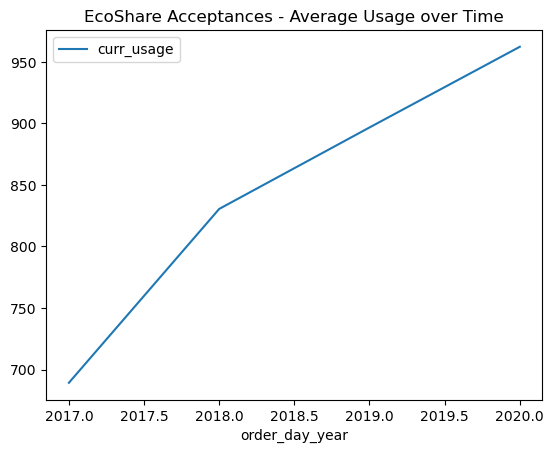

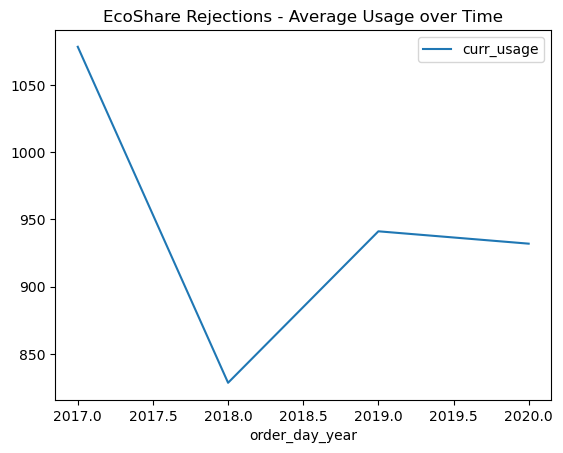

In [21]:
ecoshare_tl_accept = ecoshare.loc[ecoshare['accept'] == 1,]
ecoshare_tl_accept = ecoshare_tl_accept[['order_day_year', 'curr_usage']]

ecoshare_tl_reject = ecoshare.loc[ecoshare['accept'] == 0,]
ecoshare_tl_reject = ecoshare_tl_reject[['order_day_year', 'curr_usage']]

grouped = ecoshare_tl_accept.groupby('order_day_year').mean()
grouped.plot()
plt.title('EcoShare Acceptances - Average Usage over Time')
grouped = ecoshare_tl_reject.groupby('order_day_year').mean()
grouped.plot()
plt.title('EcoShare Rejections - Average Usage over Time')


#### Term Length
We also apply the same comparison for the length of the electricity contract they purchased from Reliant. First, we replace the non-numeric values with the yearly average and then graph.

In [22]:

# term length is in months
ecoshare.loc[(ecoshare['term_length'] == "C&") | (ecoshare['term_length'] == "MM"), 'term_length'] = np.NaN
ecoshare['term_length'] = pd.to_numeric(ecoshare['term_length'])
ecoshare['term_length'] = ecoshare['term_length'].fillna(ecoshare.groupby(['order_day_year'])['term_length'].transform('mean'), inplace = False)


ecoshare['term_length'].mean()


# apply for test data
ecoshare_test.loc[(ecoshare_test['term_length'] == "C&") | (ecoshare_test['term_length'] == "MM"), 'term_length'] = np.NaN
ecoshare_test['term_length'] = pd.to_numeric(ecoshare_test['term_length'])
ecoshare_test['term_length'] = ecoshare_test['term_length'].fillna(ecoshare_test.groupby(['order_day_year'])['term_length'].transform('mean'), inplace = False)
ecoshare_test['term_length'].mean()



18.748507392125198

Text(0.5, 1.0, 'EcoShare Acceptances - Average Term Length over Time')

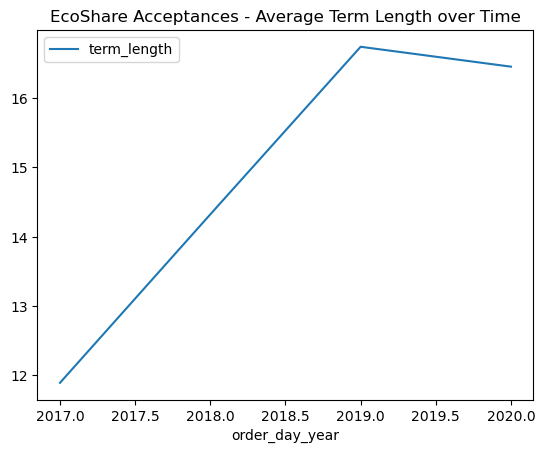

In [23]:
ecoshare_tl_accept = ecoshare.loc[ecoshare['accept'] == 1,]
ecoshare_tl_accept = ecoshare_tl_accept[['order_day_year', 'term_length']]

ecoshare_tl_reject = ecoshare.loc[ecoshare['accept'] == 0,]
ecoshare_tl_reject = ecoshare_tl_reject[['order_day_year', 'term_length']]

grouped = ecoshare_tl_accept.groupby('order_day_year').mean()
grouped.plot()
plt.title('EcoShare Acceptances - Average Term Length over Time')


Text(0.5, 1.0, 'EcoShare Rejections - Average Term Length over Time')

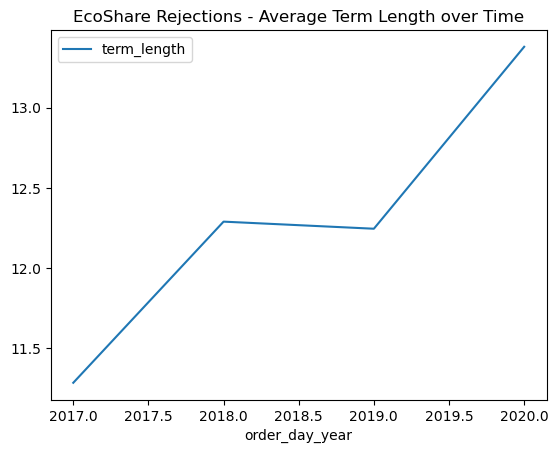

In [24]:
grouped = ecoshare_tl_reject.groupby('order_day_year').mean()
grouped.plot()
plt.title('EcoShare Rejections - Average Term Length over Time')

Term length doesn't seem to really have a strong relationship with acceptances.

#### Location
The tables below show the proportion of value in descending order for county, dma, and city, respectively. Harris and Houston seem to be where most customers are, which is expected given that NRG is located in that area.

##### County

In [25]:
ecoshare.county.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

HARRIS        40.5%
DALLAS        11.4%
TARRANT        8.9%
FORT BEND      4.6%
COLLIN         2.8%
              ...  
KENT           0.0%
HALL           0.0%
MCCULLOCH      0.0%
WOOD           0.0%
JEFF DAVIS     0.0%
Name: county, Length: 150, dtype: object

##### DMA

In [26]:
ecoshare.dma.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

HOUSTON                       51.7%
DALLAS-FT. WORTH              28.5%
ODESSA-MIDLAND                 3.4%
WACO-TEMPLE-BRYAN              3.2%
HARLINGEN-WSLCO-BRNSVL-MCA     2.6%
CORPUS CHRISTI                 2.2%
TYLER-LONGVIEW(LFKN&NCGD)      1.7%
AUSTIN                         1.5%
ABILENE-SWEETWATER             1.2%
LAREDO                         1.0%
SAN ANTONIO                    0.8%
WICHITA FALLS & LAWTON         0.8%
SAN ANGELO                     0.5%
SHERMAN-ADA                    0.4%
VICTORIA                       0.3%
LUBBOCK                        0.1%
AMARILLO                       0.0%
SHREVEPORT                     0.0%
Name: dma, dtype: object

##### City

In [27]:
ecoshare.city.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

HOUSTON        30.2%
DALLAS          6.7%
FORT WORTH      4.1%
KATY            2.0%
SPRING          2.0%
               ...  
LAMAR           0.0%
BUFFALO GAP     0.0%
PALMHURST       0.0%
STRAWN          0.0%
BARTLETT        0.0%
Name: city, Length: 620, dtype: object

#### Home Value
The graph below shows the average home value for acceptances versus rejections. There doesn't seem to be as much of a pattern here in association with EcoShare acceptance.

<AxesSubplot:xlabel='order_day_year'>

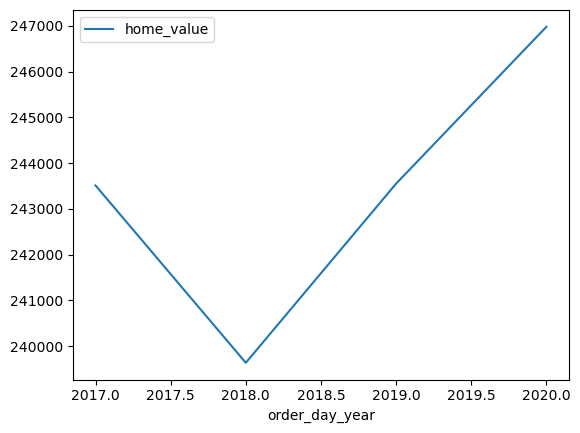

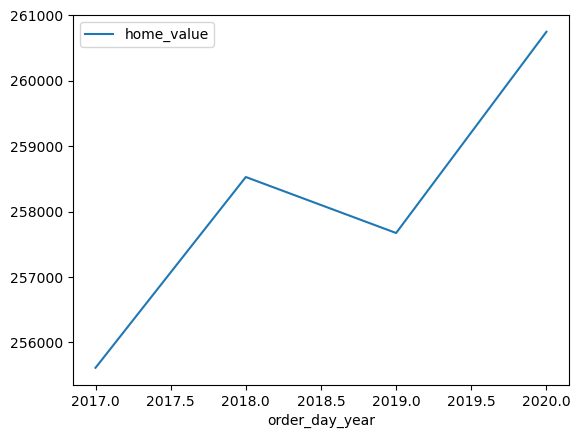

In [28]:
#home_value
# for blanks, put average basd on city and county
ecoshare['home_value'].fillna(ecoshare['home_value'].mean(), inplace = True)
ecoshare_test['home_value'].fillna(ecoshare_test['home_value'].mean(), inplace = True)

ecoshare_tl_accept = ecoshare.loc[ecoshare['accept'] == 1,]
ecoshare_tl_accept = ecoshare_tl_accept[['order_day_year', 'home_value']]

ecoshare_tl_reject = ecoshare.loc[ecoshare['accept'] == 0,]
ecoshare_tl_reject = ecoshare_tl_reject[['order_day_year', 'home_value']]

grouped = ecoshare_tl_accept.groupby('order_day_year').mean()
grouped.plot()

grouped = ecoshare_tl_reject.groupby('order_day_year').mean()
grouped.plot()

#### Dwelling Type
Below shows the type of housing over time based on call date:

In [29]:
# dwelling_type_cd # convert to categorical -- S = 1, M = 0
ecoshare['dwelling_type_cd'] = ecoshare['dwelling_type_cd'].astype('category').cat.codes
ecoshare_test['dwelling_type_cd'] = ecoshare_test['dwelling_type_cd'].astype('category').cat.codes

<AxesSubplot:xlabel='order_day_year'>

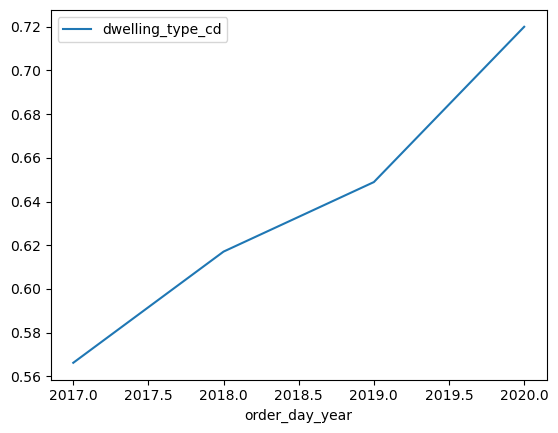

In [30]:
ecoshare_tl_dwell = ecoshare[['order_day_year', 'dwelling_type_cd']]
grouped = ecoshare_tl_dwell.groupby('order_day_year').mean()
grouped.plot()

It seems that over the years, customers are more into smaller dwelling types e.g. single family homes.

## Data Preparation and Cleaning

Here, both the training and test data is cleaned and fields have values imputed prior to modeling.

tos_flg: imputed "N" for blanks and converted to categorical variable

In [31]:
## tos_flg 

# convert blank to N and then convert to categorical
ecoshare['tos_flg'].fillna("N", inplace=True) # assume blank is N/A
ecoshare['tos_flg'] = ecoshare['tos_flg'].astype('category').cat.codes # 1 = Y, 0 = No

ecoshare_test['tos_flg'].fillna("N", inplace=True) # assume blank is N/A
ecoshare_test['tos_flg'] = ecoshare_test['tos_flg'].astype('category').cat.codes # 1 = Y, 0 = No

disconotice_flg: converted to categorical variable

In [32]:
# disconotice_flg  # convert to categorical -- # 1 = Y, 0 = No
ecoshare['disconotice_flg'] = ecoshare['disconotice_flg'].astype('category').cat.codes
ecoshare_test['disconotice_flg'] = ecoshare_test['disconotice_flg'].astype('category').cat.codes


latefee_flg: converted to categorical variable

In [33]:
# latefee_flg # convert to categorical -- # 1 = Y, 0 = No
ecoshare['latefee_flg'] = ecoshare['latefee_flg'].astype('category').cat.codes
ecoshare_test['latefee_flg'] = ecoshare_test['latefee_flg'].astype('category').cat.codes

dwelling_type_cd: converted to categorical variable

In [34]:
# dwelling_type_cd # convert to categorical -- S = 1, M = 0
ecoshare['dwelling_type_cd'] = ecoshare['dwelling_type_cd'].astype('category').cat.codes
ecoshare_test['dwelling_type_cd'] = ecoshare_test['dwelling_type_cd'].astype('category').cat.codes

curr_usage: Blanks are imputed with the yearly average, since some years have varying usages.

In [35]:
# curr_usage

ecoshare['curr_usage'] = ecoshare['curr_usage'].fillna(ecoshare.groupby(['order_day_year'])['curr_usage'].transform('mean'), inplace = False)
ecoshare_test['curr_usage'] = ecoshare_test['curr_usage'].fillna(ecoshare_test.groupby(['order_day_year'])['curr_usage'].transform('mean'), inplace = False)

ecoshare['curr_usage'].mean()

940.305169530944

product_type_cd: converted to categorical variable

In [36]:
ecoshare['product_type_cd'] = ecoshare['product_type_cd'].astype('category').cat.codes
ecoshare_test['product_type_cd'] = ecoshare_test['product_type_cd'].astype('category').cat.codes

pool: imputed blanks with "N" and converted to categorical variable

In [37]:
# pool #assume blank is No? then convert to categorical
# update blank to not provided

ecoshare['pool'].fillna("N", inplace=True)
ecoshare['pool'] = ecoshare['pool'].astype('category').cat.codes
ecoshare_test['pool'].fillna("N", inplace=True)
ecoshare_test['pool'] = ecoshare_test['pool'].astype('category').cat.codes

automatic_payment_flg: converted to categorical variable

In [38]:
# automatic_payment_flg # convert to categorical

ecoshare['automatic_payment_flg'] = ecoshare['automatic_payment_flg'].astype('category').cat.codes
ecoshare_test['automatic_payment_flg'] = ecoshare_test['automatic_payment_flg'].astype('category').cat.codes

weblog_flg: converted to categorical variable

In [39]:
# weblog_flg # convert to categorical
ecoshare['weblog_flg'] = ecoshare['weblog_flg'].astype('category').cat.codes
ecoshare_test['weblog_flg'] = ecoshare_test['weblog_flg'].astype('category').cat.codes

risk_level: converted to categorical variable

In [40]:
# risk_level
# convert to categocial - blank will be -1 (not provided)

ecoshare['risk_level'].fillna("Not Provided", inplace=True) 
ecoshare['risk_level'] = ecoshare['risk_level'].astype('category').cat.codes

ecoshare_test['risk_level'].fillna("Not Provided", inplace=True) 
ecoshare_test['risk_level'] = ecoshare_test['risk_level'].astype('category').cat.codes

deposit_onhand_amt: imputed blanks with 0

In [41]:
# deposit_onhand_amt #consider applying 0 to blanks

ecoshare['deposit_onhand_amt'].fillna(0, inplace = True)

ecoshare_test['deposit_onhand_amt'].fillna(0, inplace = True)


ebill_enroll_flag: converted to categorical variable

In [42]:
# ebill_enroll_flag # convert to categorical
ecoshare['ebill_enroll_flag'] = ecoshare['ebill_enroll_flag'].astype('category').cat.codes
ecoshare_test['ebill_enroll_flag'] = ecoshare_test['ebill_enroll_flag'].astype('category').cat.codes

called_flg: converted to categorical variable

In [43]:
# called_flg # convert to categorical

ecoshare['called_flg'] = ecoshare['called_flg'].astype('category').cat.codes
ecoshare_test['called_flg'] = ecoshare_test['called_flg'].astype('category').cat.codes

oam_flg: converted to categorical variable

In [44]:
# oam_flg # convert to categorical
ecoshare['oam_flg'] = ecoshare['oam_flg'].astype('category').cat.codes
ecoshare_test['oam_flg'] = ecoshare_test['oam_flg'].astype('category').cat.codes

sap_productname: Imputed blanks with "Not Provided" and converted to categorical variable

In [45]:
# sap_productname # convert blank to not provided and then to categorical 
ecoshare['sap_productname'].fillna("Not Provided", inplace=True) 
ecoshare['sap_productname'] = ecoshare['sap_productname'].astype('category').cat.codes

ecoshare_test['sap_productname'].fillna("Not Provided", inplace=True) 
ecoshare_test['sap_productname'] = ecoshare_test['sap_productname'].astype('category').cat.codes

disconnects_flg :converted to categorical variable

In [46]:
# disconnects_flg # convert to categorical
ecoshare['disconnects_flg'] = ecoshare['disconnects_flg'].astype('category').cat.codes
ecoshare_test['disconnects_flg'] = ecoshare_test['disconnects_flg'].astype('category').cat.codes

load_profile: Imputed blanks with "Not Provided" and then converted to categorical variable

In [47]:
# load_profile # convert to categorical and id blanks as no class category

ecoshare['load_profile'].fillna("Not Provided", inplace=True) 
ecoshare['load_profile'] = ecoshare['load_profile'].astype('category').cat.codes

ecoshare_test['load_profile'].fillna("Not Provided", inplace=True) 
ecoshare_test['load_profile'] = ecoshare_test['load_profile'].astype('category').cat.codes

city: converted to categorical variable

In [48]:
# city # convert to categorical
ecoshare['city'] = ecoshare['city'].astype('category').cat.codes
ecoshare_test['city'] = ecoshare_test['city'].astype('category').cat.codes

zipcode: converted to categorical variable

In [49]:
# zipcode # maybe don't use this?
ecoshare['zipcode'] = ecoshare['zipcode'].astype('category').cat.codes
ecoshare_test['zipcode'] = ecoshare_test['zipcode'].astype('category').cat.codes

county: converted to categorical variable

In [50]:
# county # convert to categorical
ecoshare['county'] = ecoshare['county'].astype('category').cat.codes
ecoshare_test['county'] = ecoshare_test['county'].astype('category').cat.codes

home_value: Imputed average to blanks

In [51]:
#home_value #what do wo with blanks -  maybe put average instead
# for blanks, put average basd on city and county
ecoshare['home_value'].fillna(ecoshare['home_value'].mean(), inplace = True)

ecoshare_test['home_value'].fillna(ecoshare_test['home_value'].mean(), inplace = True)

tdsp: converted to categorical variable

In [52]:
#tdsp # convert to categorical
ecoshare['tdsp'] = ecoshare['tdsp'].astype('category').cat.codes
ecoshare_test['tdsp'] = ecoshare_test['tdsp'].astype('category').cat.codes

dma: converted to categorical variable

In [53]:
#dma # convert to categorical
ecoshare['dma'] = ecoshare['dma'].astype('category').cat.codes
ecoshare_test['dma'] = ecoshare_test['dma'].astype('category').cat.codes

ev_driver: converted to categorical variable

In [54]:
#ev_driver # convert to categorical

ecoshare['ev_driver'] = ecoshare['ev_driver'].astype('category').cat.codes
ecoshare_test['ev_driver'] = ecoshare_test['ev_driver'].astype('category').cat.codes

## Dataset Setup

We look at the distribution of acceptances over time in tabular form.

In [55]:
ecoshare_usage = ecoshare[['order_day_year', 'order_day_month', 'accept']]
grouped = ecoshare_usage.groupby(['order_day_year', 'order_day_month']).agg({'accept': ['count', 'sum']})
grouped['%'] = grouped['accept']['sum']/grouped['accept']['count'] *100
#grouped['accept']['sum']
print(grouped.to_string())

                               accept                %
                                count   sum           
order_day_year order_day_month                        
2017           1                 9458  1207  12.761683
               2                 2501  1274  50.939624
               3                 2714  1424  52.468681
               4                 1988  1013  50.955734
               5                 1151   623  54.126846
               6                  721   378  52.427184
               7                  842   457  54.275534
               8                 5396   735  13.621201
               9                13431  1006   7.490135
               10                1822  1091  59.879254
               11                1225   774  63.183673
               12                1235   638  51.659919
2018           1                 1301   666  51.191391
               2                 1180   605  51.271186
               3                  501   126  25.149701
          

Given the trends of acceptance over time and that the past few years have consistently been on the lower end, the earlier years of data were excluded to avoid skewness.

In summary, the fields customer_id, meter_id, and order_date were removed. The dataset was trimmed to after a certain month in 2018 to ensure the model was based on a more stable trend of acceptances. It seems like after 2018, the acceptances have been more or less consistent through today.

Below, the test dataset is also set up.

In [56]:
# set up the training dataset

ecoshare = ecoshare.loc[ecoshare['order_day'] >= "2018-03-01"]
ecoshare = ecoshare.loc[:, ecoshare.columns != 'order_day']

ecoshare = ecoshare.loc[:, ecoshare.columns != 'customer_id']
ecoshare = ecoshare.loc[:, ecoshare.columns != 'meter_id']

X = ecoshare.loc[:, ecoshare.columns != 'accept']
#X = X_1.loc[:, X_1.columns != 'order_day_year']

y = ecoshare['accept']
X

# set up the testing dataset provided by NRG

ecoshare_test = ecoshare_test.loc[:, ecoshare_test.columns != 'order_day']

ecoshare_test = ecoshare_test.loc[:, ecoshare_test.columns != 'customer_id']
X_test_final = ecoshare_test.loc[:, ecoshare_test.columns != 'meter_id']


Because there is extreme class imbalance, we apply oversampling using SMOTE to increase the minority class by replication. (see https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/)

In [57]:
print("Before OverSampling, counts of label '1': {}".format(sum(y == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y == 0))) 

Before OverSampling, counts of label '1': 1833
Before OverSampling, counts of label '0': 34517 



In [58]:
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_resample(X, y) 

In [59]:

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

After OverSampling, the shape of train_X: (69034, 31)
After OverSampling, the shape of train_y: (69034,) 

After OverSampling, counts of label '1': 34517
After OverSampling, counts of label '0': 34517


#### Correlation Heatmap

Below is a correlation heatmap to evaluate the relationships among all the features.

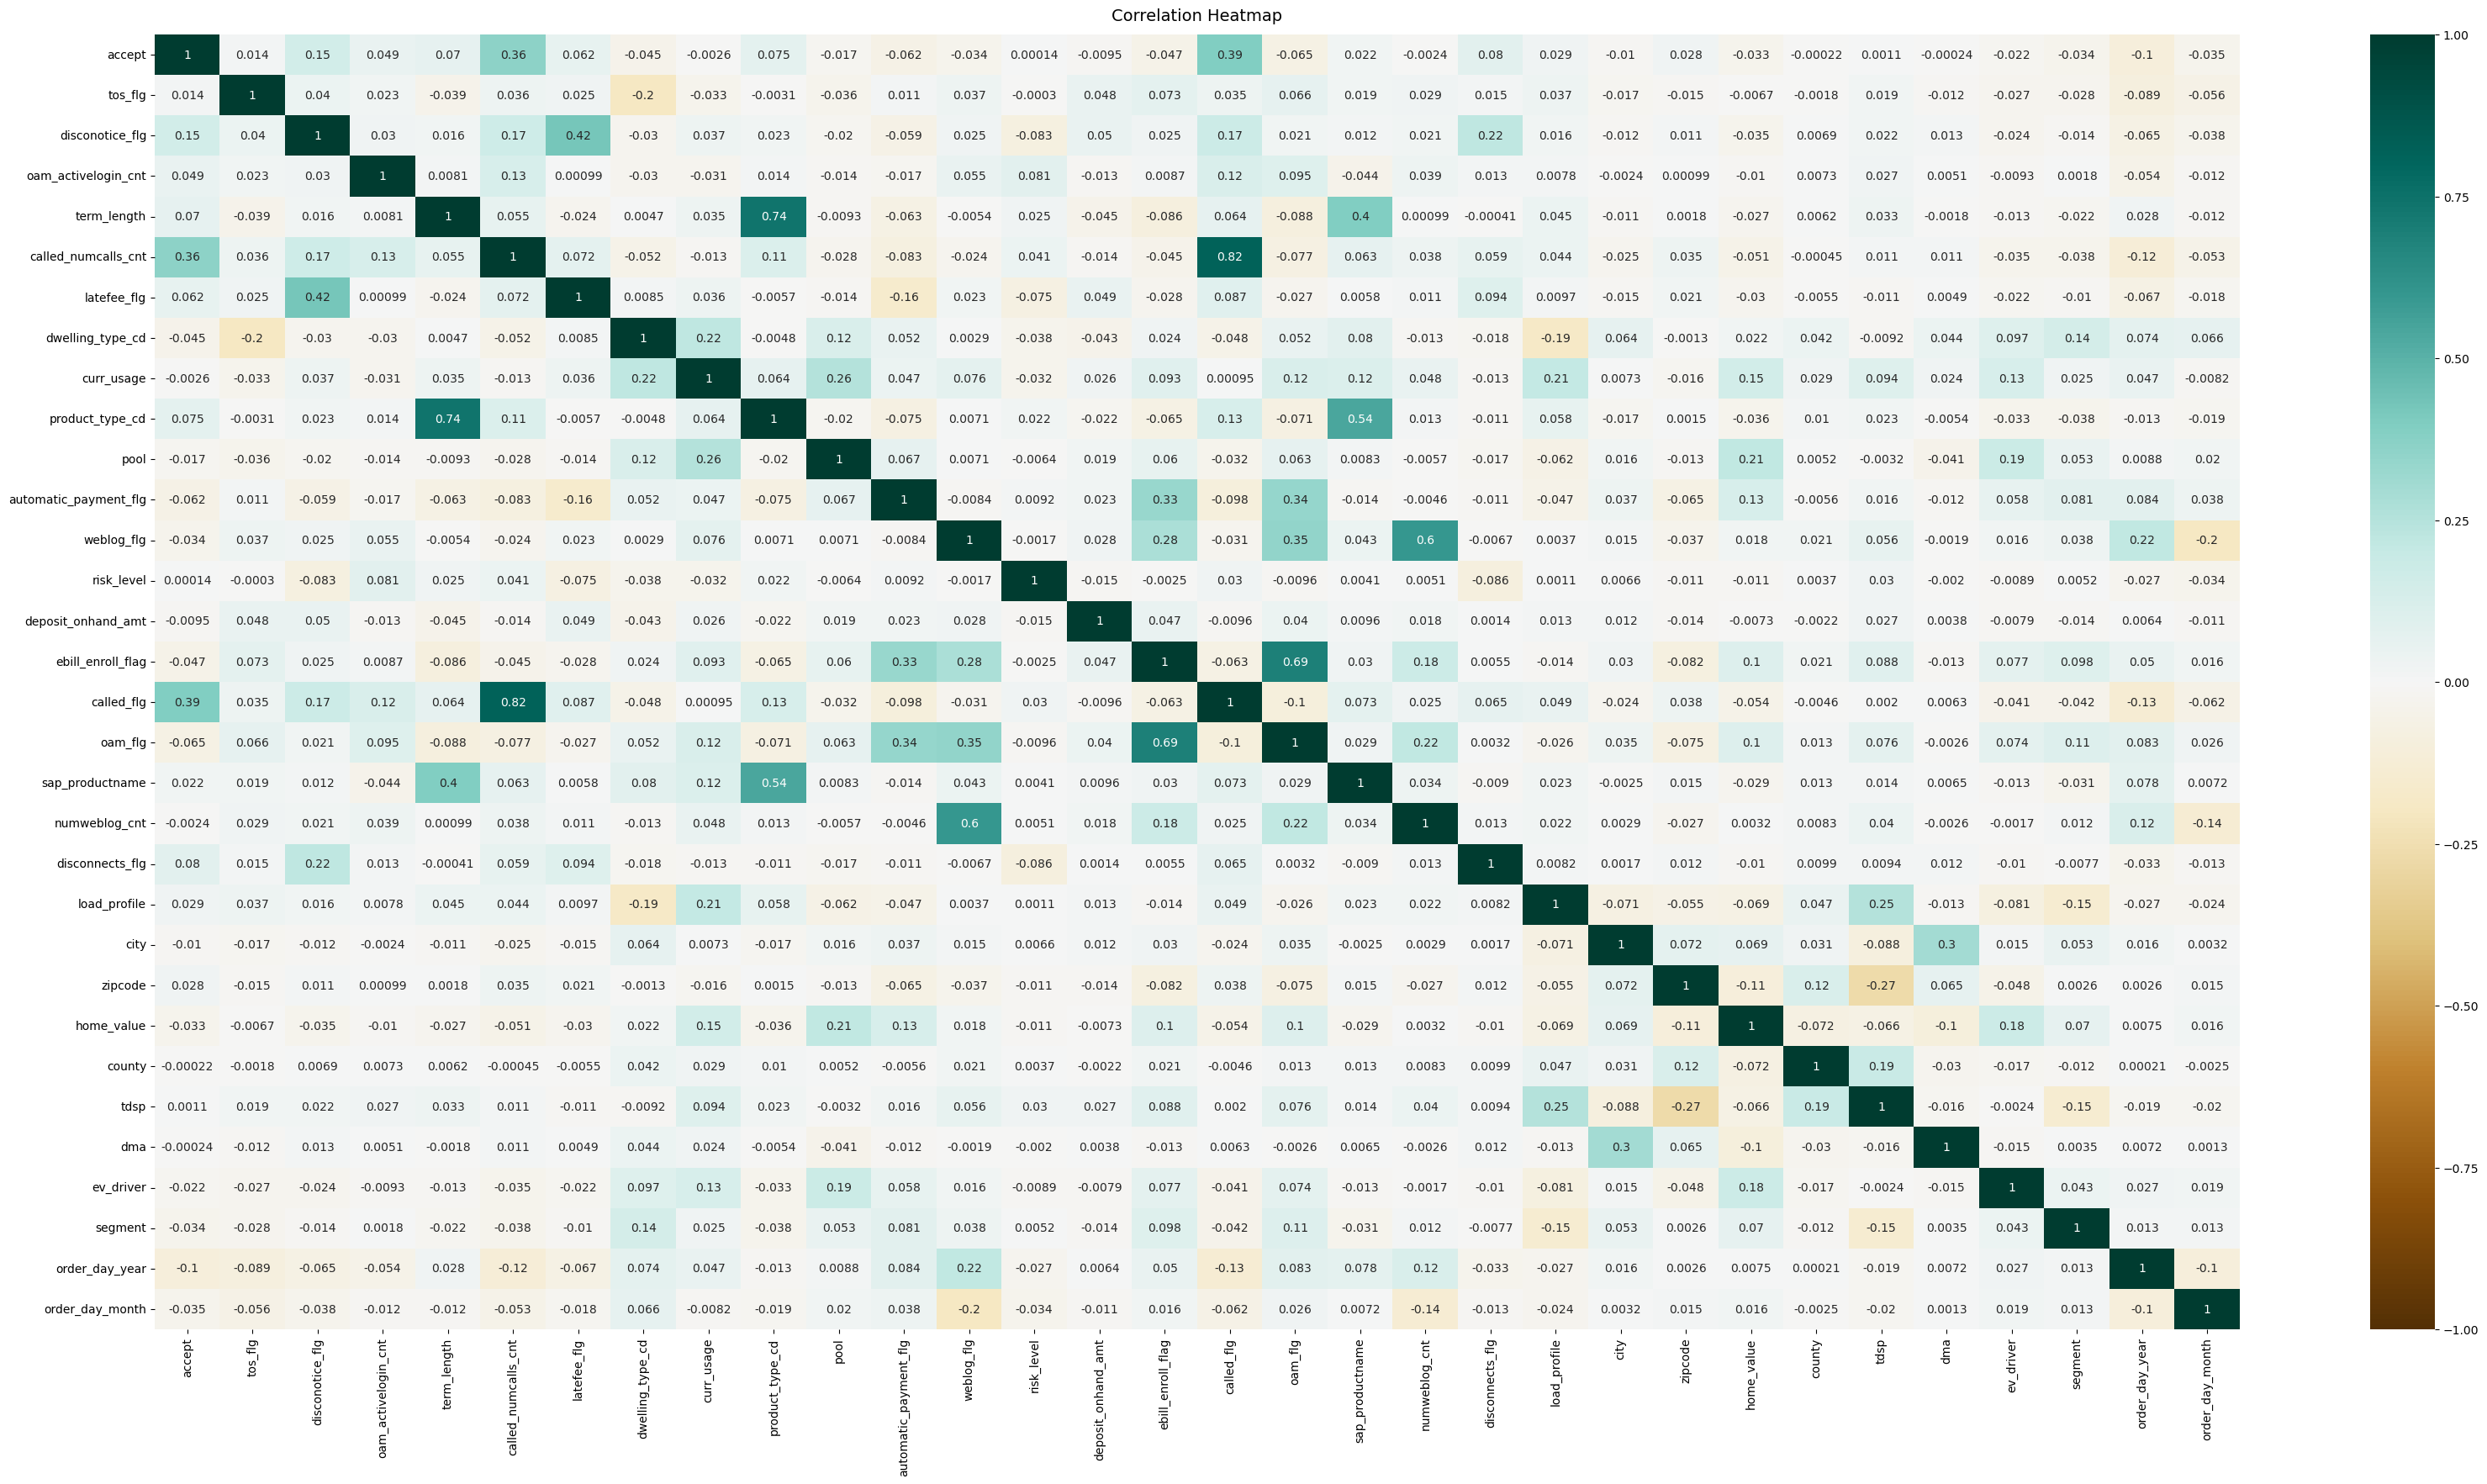

In [60]:
# sns histogram seaborn correlation heat map

plt.figure(figsize=(40, 20))
heatmap = sns.heatmap(ecoshare.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

# disconnotice flag, called num calls count, product type, called_flg, year

From the heatmap, the number of calls and whether the customer calls is more strongly associated with whether EcoShare was accepted. Disconnotice flag (whether the customer recently received a disconnect notice from Reliant for not paying their electricity bill) also seems to have some relationship with acceptance. However, there is also some evidence of multicollinearity including:

- product type cd and term length (0.74)
- called flag and num calls (0.82)
- sap product name and term length (0.4)
- disconnotice flag and late fee flg (0.42)
- oam flag and ebill (0.69)
- oam with automatic payment and weblog (0.34-0.35)
- numweblog and weblog (0.6)

There are also strong inverse correlation including:
- tos_flag and dwelling type cd (-0.2)
- late fee flag and auto payment (-0.16)
- zip code and tdsp (-0.27)


## Method 1: Extra Trees with All Features

Here we attempt to model the data using an extra tree classifier. This is similar to a regular random forest where both are made up of decision trees and then the growing method is the same where at each node, there is random selection of the feature to be added there. However, extra trees is based on the original sample of data rather than bootstrapping. The selection of where to split is selected randomly.

First, split the dataset with 80% as training and 20% as test.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_train_res, y_train_res, test_size=0.2)

We then apply the model to the training dataset.

In [62]:
# Building the model

extra_tree_forest = ExtraTreesClassifier(n_estimators = 10,
                                        criterion ='entropy')
 
# Training the model
extra_tree_forest.fit(X_train, y_train)
 

ExtraTreesClassifier(criterion='entropy', n_estimators=10)

Apply cross-validation:

In [63]:
# cross validation

cv_scores = cross_val_score(extra_tree_forest, X_train, y_train, cv=5 )
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.96


The CV accuracy is 0.96. Then, we predict based on the model and score on the test set that was created.

In [64]:
ypred = (extra_tree_forest.predict_proba(X_test)[:,1] >= 0.5).astype(bool)
cm = confusion_matrix(y_test, ypred)
cm

array([[6538,  420],
       [ 146, 6703]])

Lastly, generate the evaluation metrics:

In [65]:
### Statistical Measures

m1_accuracy = accuracy_score(y_test, ypred)
m1_balanced_accuracy = metrics.balanced_accuracy_score(y_test, ypred)
# Precision
m1_precision = precision_score(y_test, ypred)
# Recall
m1_recall = recall_score(y_test, ypred)
# AUC-ROC
m1_auc = metrics.roc_auc_score(y_test, ypred)
# F1 Score
m1_f1_score = metrics.f1_score(y_test, ypred)
# Specificity
m1_specificity = metrics.recall_score(y_test, ypred)
# AUC-PR
m1_auc_pr = metrics.average_precision_score(y_test, ypred)

print("Accuracy:", m1_accuracy)
print("Balanced Accuracy:", m1_balanced_accuracy)
print("Precision:", m1_precision)
print("Recall:", m1_recall)
print("AUC-ROC:", m1_auc)
print("F1 Score:", m1_f1_score)
print("Specificity:", m1_specificity)
print("AUC-PR:", m1_auc_pr)

Accuracy: 0.9590063011515898
Balanced Accuracy: 0.9591604231903319
Precision: 0.941036080303243
Recall: 0.9786830194188932
AUC-ROC: 0.959160423190332
F1 Score: 0.9594904093902089
Specificity: 0.9786830194188932
AUC-PR: 0.9315503787993543


Plot the ROC curve:

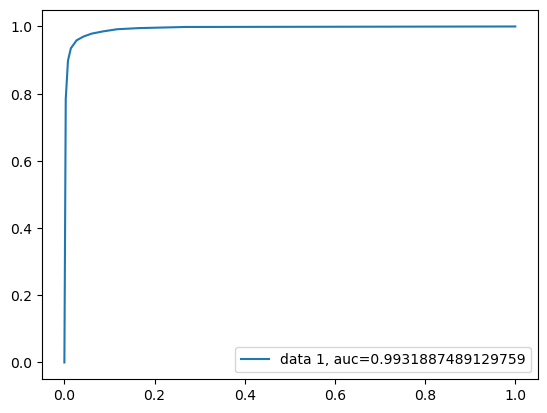

In [66]:
# AUC-ROC
# ROC Curve
y_pred_proba = extra_tree_forest.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

The accuracy is around 96% as well as the AUC. Below is the precision recall chart.

(0.0, 1.0)

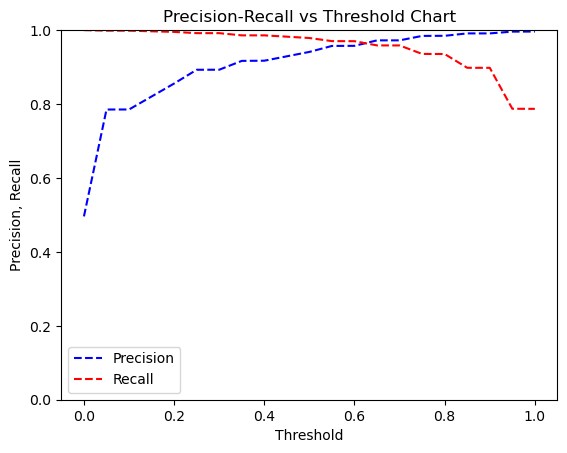

In [67]:
probs_y = extra_tree_forest.predict_proba(X_test) 

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 
1]) 

pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

## Method 2: Extra Trees with Top 8 Features

Here, we first plot the importance graph for the extra trees model.

<AxesSubplot:ylabel='allvarlist'>

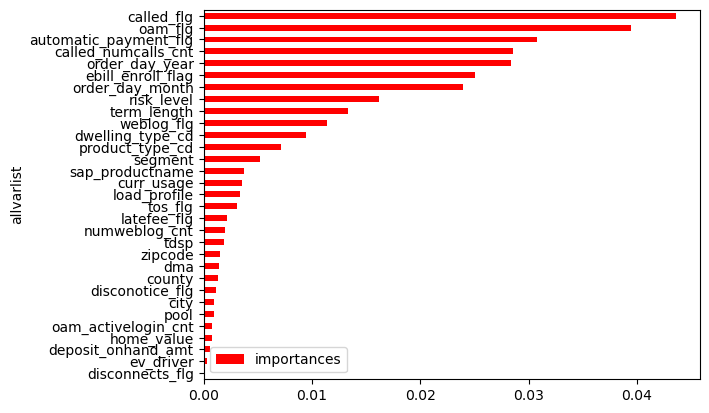

In [68]:
# Computing the importance of each feature
feature_importance = extra_tree_forest.feature_importances_
 
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in
                                        extra_tree_forest.estimators_],
                                        axis = 0)

df3=pd.DataFrame({'allvarlist':X.columns,'importances':feature_importance_normalized})
df3.sort_values('importances',inplace=True)
df3.plot(kind='barh',y='importances',x='allvarlist',color='r')


It seems like whether the customer called within the last month, the month and year of the order date, oam_flg, automatic_payment_flg, and the risk level (whether the customer is at risk of not paying their electricity bill, grouped into low risk (L), medium risk (M), and high risk (H)) are some of the top features that impact the acceptance. There may be more calls for customers at risk of not paying and hence the pitches for ecoshare for those customers may not really succeed, as the focus of the call would be more on payment/billing.

Now, we use the top features for the model and then train it.

In [69]:
extra_trees_short = X_train_res[['called_flg', "order_day_year", "order_day_month", "oam_flg", "called_numcalls_cnt", "risk_level", "ebill_enroll_flag", "dwelling_type_cd"]]

X_train, X_test, y_train, y_test = train_test_split(extra_trees_short, y_train_res, test_size=0.2)

In [70]:
extra_tree_forest = ExtraTreesClassifier(n_estimators = 8,
                                        criterion ='entropy')
 
# Training the model
extra_tree_forest.fit(X_train, y_train)


ExtraTreesClassifier(criterion='entropy', n_estimators=8)

Apply cross-validation:

In [71]:
# cv
# cross validation

cv_scores = cross_val_score(extra_tree_forest, X_train, y_train, cv=5 )
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.92


The predictions are generated. The confusion matrix is provided below for this model and then the evaluation metrics are generated including the accuracy.

In [72]:
ypred = (extra_tree_forest.predict_proba(X_test)[:,1] >= 0.5).astype(bool)
cm = confusion_matrix(y_test, ypred)
cm

array([[5958,  829],
       [ 287, 6733]])

In [73]:
### Statistical Measures

m2_accuracy = accuracy_score(y_test, ypred)
m2_balanced_accuracy = metrics.balanced_accuracy_score(y_test, ypred)
# Precision
m2_precision = precision_score(y_test, ypred)
# Recall
m2_recall = recall_score(y_test, ypred)
# AUC-ROC
m2_auc = metrics.roc_auc_score(y_test, ypred)
# F1 Score
m2_f1_score = metrics.f1_score(y_test, ypred)
# Specificity
m2_specificity = metrics.recall_score(y_test, ypred)
# AUC-PR
m2_auc_pr = metrics.average_precision_score(y_test, ypred)

print("Accuracy:", m2_accuracy)
print("Balanced Accuracy:", m2_balanced_accuracy)
print("Precision:", m2_precision)
print("Recall:", m2_recall)
print("AUC-ROC:", m2_auc)
print("F1 Score:", m2_f1_score)
print("Specificity:", m2_specificity)
print("AUC-PR:", m2_auc_pr)


Accuracy: 0.9191714347794597
Balanced Accuracy: 0.9184857656899796
Precision: 0.8903729172176673
Recall: 0.9591168091168091
AUC-ROC: 0.9184857656899795
F1 Score: 0.9234672884378001
Specificity: 0.9591168091168091
AUC-PR: 0.874758188829109


Plot the ROC and PR charts:

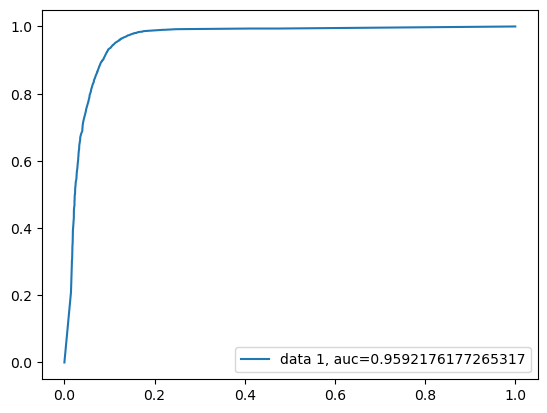

In [74]:
# AUC-ROC
# ROC Curve
y_pred_proba = extra_tree_forest.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

(0.0, 1.0)

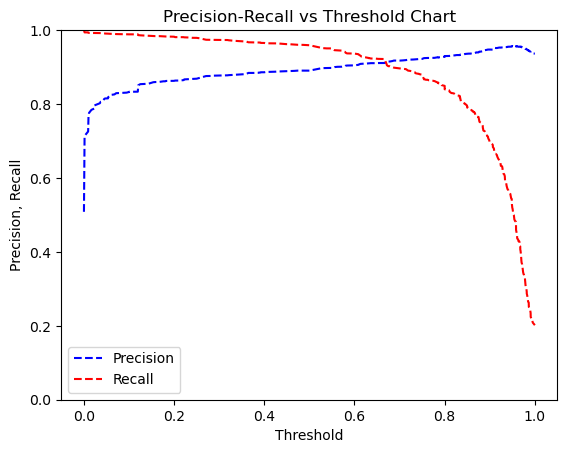

In [75]:
probs_y=extra_tree_forest.predict_proba(X_test) 

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 
1]) 

pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

Taking the top features results in a an accuracy of about 92% and AUC of almost 0.96.

## METHOD 3: Random Forest with All Features

This next model is a random forest applied to all features.

Train the random forest model:

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_train_res, y_train_res, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

Apply cross-validation:

In [77]:
# cross validation

cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.97


Score against the test set and get the accuracy metrics:

In [78]:
y_pred = (rf.predict(X_test) >= 0.5).astype(bool)

In [79]:
### Statistical Measures

m3_accuracy = accuracy_score(y_test, y_pred)
m3_balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
# Precision
m3_precision = precision_score(y_test, y_pred)
# Recall
m3_recall = recall_score(y_test, y_pred)
# AUC-ROC
m3_auc = metrics.roc_auc_score(y_test, y_pred)
# F1 Score
m3_f1_score = metrics.f1_score(y_test, y_pred)
# Specificity
m3_specificity = metrics.recall_score(y_test, y_pred)
# AUC-PR
m3_auc_pr = metrics.average_precision_score(y_test, y_pred)

print("Accuracy:", m3_accuracy)
print("Balanced Accuracy:", m3_balanced_accuracy)
print("Precision:", m3_precision)
print("Recall:", m3_recall)
print("AUC-ROC:", m3_auc)
print("F1 Score:", m3_f1_score)
print("Specificity:", m3_specificity)
print("AUC-PR:", m3_auc_pr)


Accuracy: 0.9703049177953212
Balanced Accuracy: 0.9703374902914264
Precision: 0.9665988963113564
Recall: 0.9736688121708601
AUC-ROC: 0.9703374902914262
F1 Score: 0.970120973619006
Specificity: 0.9736688121708601
AUC-PR: 0.9541840645752945


The accuracy is close to 97%, and the precision/recall is around there as well.

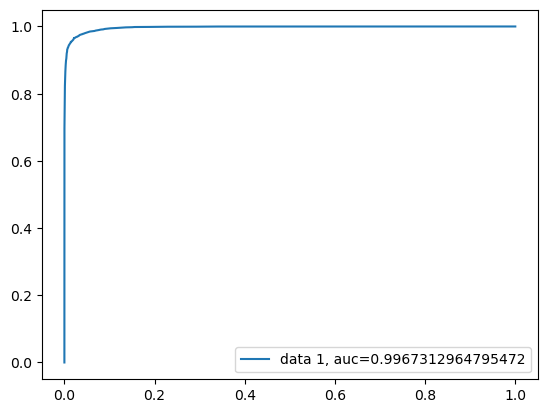

In [80]:
# AUC-ROC
# ROC Curve
y_pred_proba = rf.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

(0.0, 1.0)

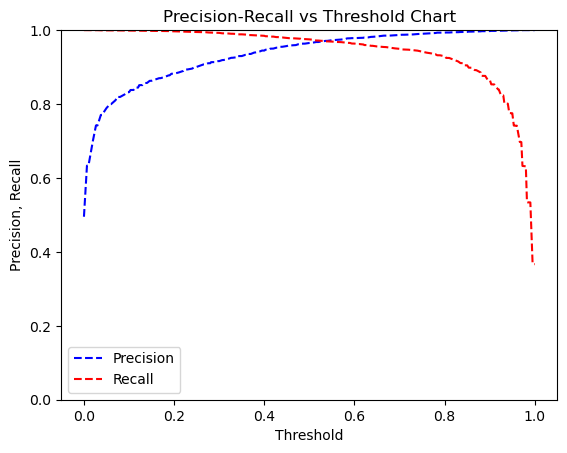

In [81]:
# PR Curve
probs_y=rf.predict_proba(X_test) 

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 
1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

## Method 4: Logistic Regression with Top Features

For logistic regression modeling, we first look at the features by importance and then use the top ones for the model. The importance is calculated based on the absolute values of the coefficients of the model output.

<AxesSubplot:ylabel='Feature'>

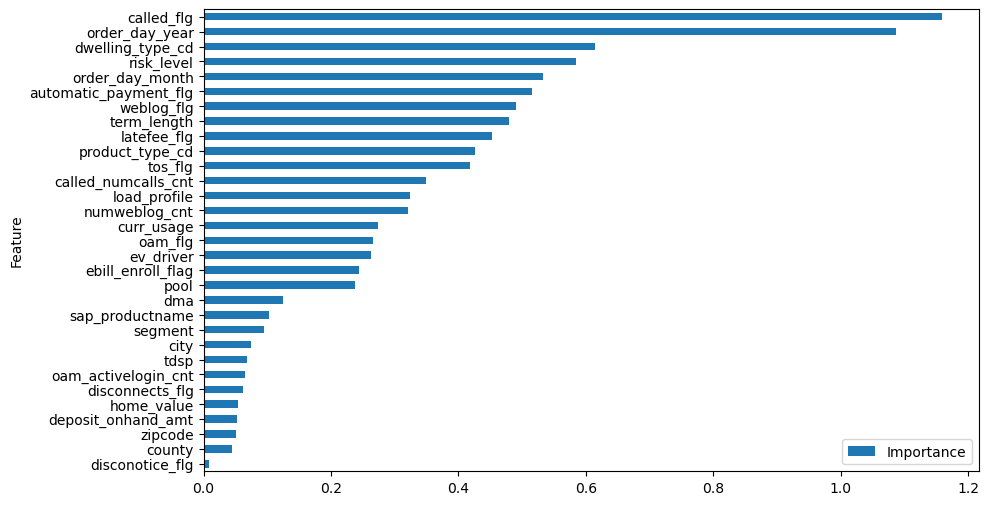

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_train_res, y_train_res, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)


coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))


Now, filter for those top 8 important features and then apply the data split and then scale to improve convergence.

In [83]:
X_top = X_train_res[["called_flg", "order_day_year","dwelling_type_cd","risk_level",
           "order_day_month", "weblog_flg", 
           "automatic_payment_flg", "term_length"]]

X_top_train, X_top_test, y_top_train, y_top_test = train_test_split(X_top, y_train_res, test_size=0.2)

scaler = StandardScaler()
X_top_train_scale = scaler.fit_transform(X_top_train)
X_top_test_scale = scaler.transform(X_top_test)


Fit the model:

In [84]:
# fit the model with data
model = LogisticRegression()
model.fit(X_top_train_scale, y_top_train)

LogisticRegression()

Apply cv:

In [85]:
k = 5

kf = model_selection.KFold(n_splits=k, random_state=None)
cv_model = LogisticRegression(solver= 'liblinear')
result = cross_val_score(cv_model, X_top_train, y_top_train, cv = kf)

print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: 0.8285258608656324


Get predictions and accuracy metrics below:

In [86]:
# fit the model with data

y_top_pred = np.where(model.predict_proba(X_top_test_scale)[:,1] >= 0.5, 1, 0)

In [87]:
confusion_matrix(y_top_test, y_top_pred)

array([[5941,  931],
       [1061, 5874]])

In [88]:
### Statistical Measures

y_pred_proba = model.predict_proba(X_top_test_scale)[::,1]

m4_accuracy = accuracy_score(y_top_test, y_top_pred)
m4_balanced_accuracy = metrics.balanced_accuracy_score(y_top_test, y_top_pred)
# Precision
m4_precision = precision_score(y_top_test, y_top_pred)
# Recall
m4_recall = recall_score(y_top_test, y_top_pred)
# AUC-ROC
m4_auc = metrics.roc_auc_score(y_top_test, y_pred_proba)
# F1 Score
m4_f1_score = metrics.f1_score(y_top_test, y_top_pred)
# Specificity
m4_specificity = metrics.recall_score(y_top_test, y_top_pred)
# AUC-PR
m4_auc_pr = metrics.average_precision_score(y_top_test, y_top_pred)

print("Accuracy:", m4_accuracy)
print("Balanced Accuracy:", m4_balanced_accuracy)
print("Precision:", m4_precision)
print("Recall:", m4_recall)
print("AUC-ROC:", m4_auc)
print("F1 Score:", m4_f1_score)
print("Specificity:", m4_specificity)
print("AUC-PR:", m4_auc_pr)



Accuracy: 0.8557253567031216
Balanced Accuracy: 0.8557653158003848
Precision: 0.8631888317413666
Recall: 0.8470079307858688
AUC-ROC: 0.9228945416989457
F1 Score: 0.8550218340611353
Specificity: 0.8470079307858688
AUC-PR: 0.8079728648340537


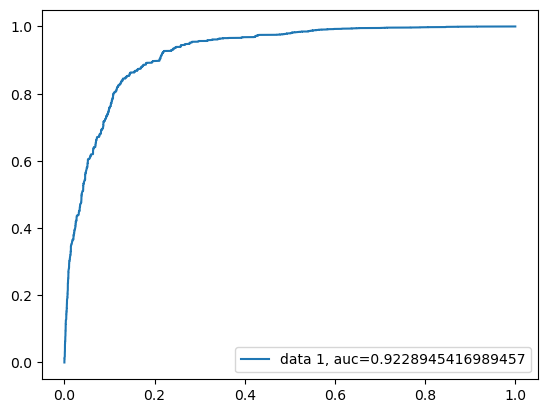

In [89]:
# AUC-ROC
# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_top_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_top_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

(0.0, 1.0)

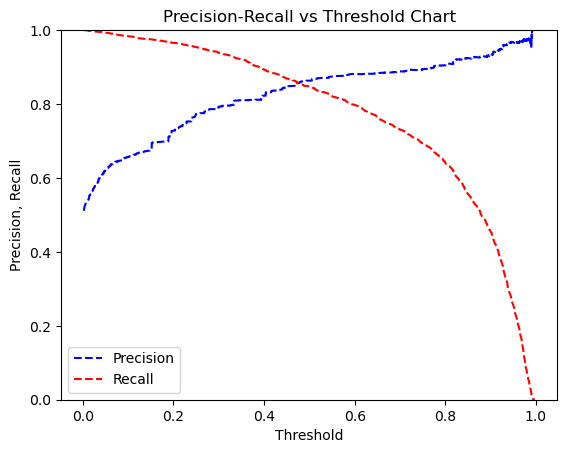

In [90]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_top_test, y_pred_proba) 
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

Graph the ROC curve and get the area under the curve:

The accuracy is around 86% with an AUC of about 0.93. This is fairly good.

### Comparing Metrics

Now, we compare the accuracy, F1 (since it's an average of the precision and recall), and the specificity scores.

In [91]:
print("Method 1 Accuracy:", m1_accuracy)
print("Method 2 Accuracy:", m2_accuracy)
print("Method 3 Accuracy:", m3_accuracy)
print("Method 4 Accuracy:", m4_accuracy)

Method 1 Accuracy: 0.9590063011515898
Method 2 Accuracy: 0.9191714347794597
Method 3 Accuracy: 0.9703049177953212
Method 4 Accuracy: 0.8557253567031216


In [97]:
print("Method 1 Precision:", m1_precision)
print("Method 2 Precision:", m2_precision)
print("Method 3 Precision:", m3_precision)
print("Method 4 Precision:", m4_precision)

Method 1 Precision: 0.941036080303243
Method 2 Precision: 0.8903729172176673
Method 3 Precision: 0.9665988963113564
Method 4 Precision: 0.8631888317413666


In [92]:
print("Method 1 F1:", m1_f1_score)
print("Method 2 F1:", m2_f1_score)
print("Method 3 F1:", m3_f1_score)
print("Method 4 F1:", m4_f1_score)

Method 1 F1: 0.9594904093902089
Method 2 F1: 0.9234672884378001
Method 3 F1: 0.970120973619006
Method 4 F1: 0.8550218340611353


In [93]:
print("Method 1 Specificity:", m1_specificity) # true negative rate
print("Method 2 Specificity:", m2_specificity)
print("Method 3 Specificity:", m3_specificity)
print("Method 4 Specificity:", m4_specificity)

Method 1 Specificity: 0.9786830194188932
Method 2 Specificity: 0.9591168091168091
Method 3 Specificity: 0.9736688121708601
Method 4 Specificity: 0.8470079307858688


In [94]:
print("Method 1 AUC:", m1_auc)
print("Method 2 AUC:", m2_auc)
print("Method 3 AUC:", m3_auc)
print("Method 4 AUC:", m4_auc)

Method 1 AUC: 0.959160423190332
Method 2 AUC: 0.9184857656899795
Method 3 AUC: 0.9703374902914262
Method 4 AUC: 0.9228945416989457


Overall, Method 3 - Random Forest seems to perform best holistically.

### Probabilities

Here, we generate the probabilities and prepare into a pickle file. This is based on Method 3 - Random Forest with All Features.

In [95]:
practicum_probabilities = rf.predict_proba(X_test_final)[:, 1]

In [96]:
# test out the pickle file extraction
def read_pickle_and_extract_info(file_path):
    try:
        # Read the pickle file
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
        
        # Extract information from the filename
        file_name = os.path.basename(file_path)
        if "_predictions.pkl" in file_name:
            info = file_name.split("_predictions.pkl")[0]
        else:
            info = None

        # Convert the data to a pandas DataFrame
        df = pd.DataFrame(data)
        
        return df, info

    except Exception as e:
        print(f"Error: {str(e)}")
        return None, None

read_pickle_and_extract_info('/Users/deborahchang/Downloads/deborah_chang_predictions.pkl')


(   0      1      2      3      4      5      6      7      8      9      ...  \
 0    0.0    0.0   0.28   0.21    0.0   0.01   0.02   0.02    0.0   0.01  ...   
 
    20318  20319  20320  20321  20322  20323  20324  20325  20326  20327  
 0   0.52   0.16    0.1    0.4   0.37   0.36   0.39   0.36   0.08   0.42  
 
 [1 rows x 20328 columns],
 'deborah_chang')